In [35]:
import json
import time
from typing import Dict

from datasets import load_dataset, load_from_disk# type: ignore
from datasets.formatting.formatting import LazyBatch # type: ignore
from huggingface_hub import list_datasets # type: ignore
import matplotlib.pyplot as plt
from minio import Minio
from minio.datatypes import Object
from minio.helpers import ObjectWriteResult
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
from transformers import AutoModel, AutoTokenizer
from transformers.tokenization_utils_base import BatchEncoding

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import set_style
import statsmodels as sm

Loading the dataset

In [36]:
data = load_from_disk('Merged_Close_feature_sp_date')
data

DatasetDict({
    train: Dataset({
        features: ['Date', 'Close', 'hidden_state'],
        num_rows: 222
    })
    validation: Dataset({
        features: ['Date', 'Close', 'hidden_state'],
        num_rows: 22
    })
    test: Dataset({
        features: ['Date', 'Close', 'hidden_state'],
        num_rows: 24
    })
})

Transforming to pandas data frame

In [37]:

ds_train = data['train']
ds_test = data['test']
ds_val = data['validation']

df_train = pd.DataFrame(ds_train)
df_test = pd.DataFrame(ds_test)
df_val = pd.DataFrame(ds_val)


    

In [38]:
df_train['Close_numeric']=np.nan
df_test['Close_numeric']=np.nan
df_val['Close_numeric']=np.nan
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           222 non-null    datetime64[ns]
 1   Close          209 non-null    object        
 2   hidden_state   222 non-null    object        
 3   Close_numeric  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 7.1+ KB


In [39]:
print(df_test['Close'][0])

4,594.63


In [40]:
for i in range(0, len(df_train)):
    if df_train['Close'][i] != None:
        df_train['Close_numeric'][i] = float(df_train['Close'][i].replace(',', ''))

for i in range(0, len(df_test)):
    if df_test['Close'][i] != None:
        df_test['Close_numeric'][i] = float(df_test['Close'][i].replace(',', ''))
    
for i in range(0, len(df_val)):
    if df_val['Close'][i] != None:
        df_val['Close_numeric'][i] = float(df_val['Close'][i].replace(',', ''))

/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_1696/2016532180.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_train['Close_numeric'][i] = float(df_train['Close'][i].replace(',', ''))
/var/folders/g7/0r52jtgn0lx64hw0zmgwgr

In [41]:
df_val.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           22 non-null     datetime64[ns]
 1   Close          21 non-null     object        
 2   hidden_state   22 non-null     object        
 3   Close_numeric  21 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 836.0+ bytes


Treat missing values

In [42]:
df_train['Close_numeric'].interpolate(method='nearest', inplace=True)
df_test['Close_numeric'].interpolate(method='nearest', inplace=True)
df_val['Close_numeric'].interpolate(method='nearest', inplace=True)
df_train['Close_numeric'].fillna(method='ffill', inplace=True)
df_test['Close_numeric'].fillna(method='ffill', inplace=True)
df_val['Close_numeric'].fillna(method='ffill', inplace=True)
# Other methods: 'polynomial', 'spline', 'quadratic'
#df_train['Close'].interpolate(method='polynomial', order=2, inplace=True)  # Polynomial interpolation of order 2
df_train['Close_numeric'][0]=df_train['Close_numeric'][1]

/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_1696/1180019333.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Close_numeric'].interpolate(method='nearest', inplace=True)
/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_1696/1180019333.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

Creating the Diff column

In [43]:
df_test['Diff']=df_test.Close_numeric.diff()
df_test['Diff'][0]=0

df_train['Diff']=df_train.Close_numeric.diff()
df_train['Diff'][0]=0

df_val['Diff']=df_val.Close_numeric.diff()
df_val['Diff'][0]=0

/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_1696/3202477990.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_test['Diff'][0]=0
/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_1696/3202477990.py:2: SettingWithC

In [44]:
len(df_train.hidden_state.iloc[2])

768

In [45]:
df_train_val=pd.concat([df_train, df_val], axis=0, ignore_index=True)
df_train_val['Diff']=df_train_val.Close_numeric.diff()
df_train_val['Diff'][0]=0

/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_1696/3224947219.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_train_val['Diff'][0]=0
/var/folders/g7/0r52jtgn0lx64hw0zmgwgr2h0000gn/T/ipykernel_1696/3224947219.py:3: Setting

In [46]:
df_train_val['Diff']

0       0.00
1       0.00
2      28.83
3     -44.87
4      86.98
       ...  
239     2.72
240    -8.91
241     4.46
242    -4.31
243    17.22
Name: Diff, Length: 244, dtype: float64

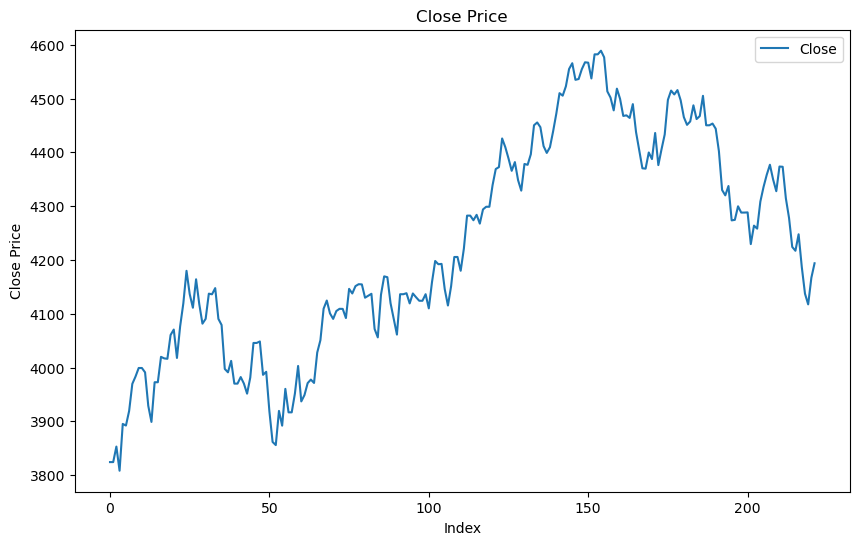

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(df_train['Close_numeric'])), df_train['Close_numeric'], label='Close')
plt.title('Close Price')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.savefig('SP500_Close_Price.png')
plt.show()


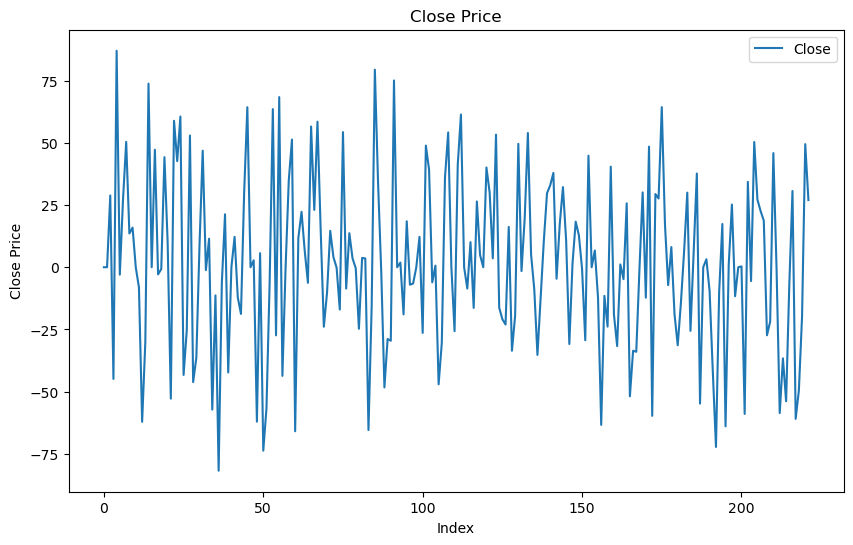

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(df_train['Close_numeric'])), df_train.Diff, label='Close')
plt.title('Close Price')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Exponential Smoothing

In [49]:
from statsmodels.tsa.api import SimpleExpSmoothing
simp_exp_smooth = SimpleExpSmoothing(df_train.Close_numeric.values).fit(smoothing_level=.8,
                                                                             optimized=False)

In [50]:
df_train.columns

Index(['Date', 'Close', 'hidden_state', 'Close_numeric', 'Diff'], dtype='object')

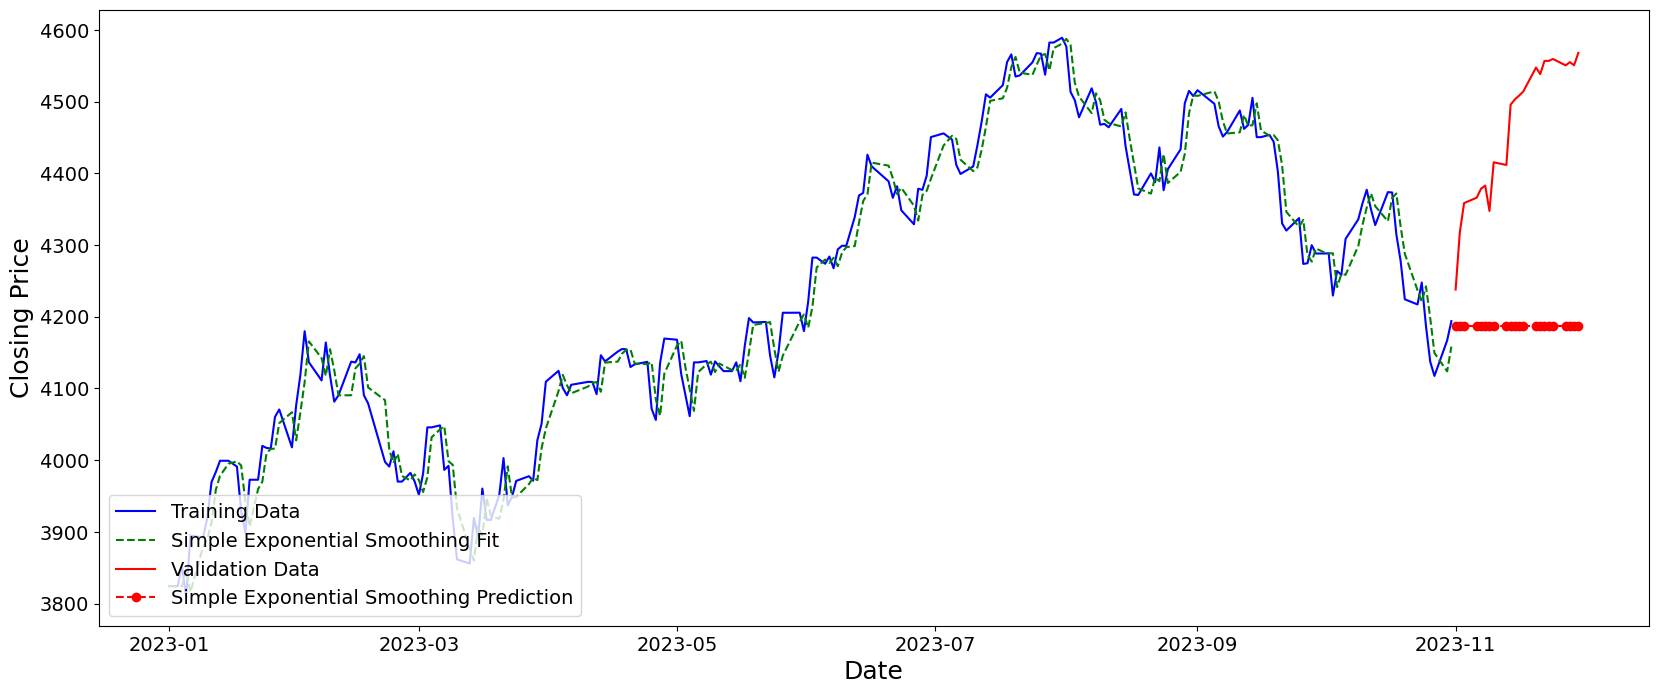

In [51]:
plt.figure(figsize=(20,8))


plt.plot(df_train.Date, 
         df_train.Close_numeric,
         'b',
         label="Training Data")


## We can get the fitted values with fittedvalues
plt.plot(df_train.Date, 
         simp_exp_smooth.fittedvalues,
         'g--',
         label="Simple Exponential Smoothing Fit")

plt.plot(df_val.Date, 
         df_val.Close_numeric,
         'r',
         label="Validation Data")

## We can get the forecast with .forecast(h)
plt.plot(df_val.Date, 
         simp_exp_smooth.forecast(len(df_val)),
         'r--o',
         label="Simple Exponential Smoothing Prediction")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

In [52]:
# This function takes 3 numpy arrays as inputs.
# It returns the 
# mean absolute error of the forecast on the test set 
# relative to the
# mean absolute error of the naive forecast on the training set over an equivalent horizon.
# 
# If MASE > 1 then your forecast performs worse out of sample than naive forecast does in sample.
# If MASE < 1 then your forecast performs better out of sample than naive forecast does in sample.

def mase(y_train, y_test, y_preds):
    n = len(y_train)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        denom += np.abs(y_train[i+1:i+m+1] - y_train[i]*np.ones(m)).mean()
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom

# Example calculation

print('MASE = ', mase(y_train = np.array([1,2,3,4,5]), y_test = np.array([6,7]), y_preds = np.array([3, 3])))


MASE =  2.3333333333333335


In [53]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

cv = TimeSeriesSplit(n_splits=10, test_size=len(df_val))

exp_mase = np.zeros((10, 10))
exp_rmse = np.zeros((10, 10))
exp_mape = np.zeros((10, 10))

i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index].copy()# your code here
    df_ho = df_train_val.iloc[test_index].copy()# your code here
    
    j = 0
    for alpha in np.linspace(0.1, 1,10):
        simp_exp_smooth = SimpleExpSmoothing(df_tt.Close_numeric.values).fit(smoothing_level=alpha,
                                                                             optimized=False)
        pred = simp_exp_smooth.forecast(len(df_ho))
        
        exp_mase[i,j] = mase(df_tt.Close_numeric.values,df_ho.Close_numeric.values,pred)# your code here
        exp_rmse[i,j]=np.sqrt(mean_squared_error(pred,df_ho.Close_numeric.values))
        exp_mape[i,j] = mean_absolute_percentage_error(df_ho.Close_numeric.values,pred)

        j = j + 1
    i = i + 1

In [54]:
exp_rmse.mean(axis=0)

array([128.76378994, 121.92529987, 120.03168253, 119.06239955,
       118.23378081, 117.50848003, 116.90641184, 116.40745007,
       115.97080728, 115.55755351])

In [55]:
alphas=np.linspace(0.1, 1,10)[np.argmin(exp_mase.mean(axis=0))]

In [56]:
alphas

1.0

In [57]:
exp_mase.mean(axis=0)


array([1.23154274, 1.18583137, 1.1701424 , 1.15666066, 1.14547706,
       1.13577285, 1.12595477, 1.11708297, 1.10908207, 1.10137201])

In [58]:
alphas

1.0

In [59]:
print('EXP CV MASE:', np.mean(exp_mase, axis=0).min(), ', EXP CV RMSE:', np.mean(exp_rmse, axis=0).min())

EXP CV MASE: 1.1013720086324834 , EXP CV RMSE: 115.55755350905766


In [104]:
cv = TimeSeriesSplit(n_splits=len(df_test), test_size=1)

exp_mase = np.zeros((len(df_test), 10))
exp_rmse = np.zeros((len(df_test), 10))
exp_mape = np.zeros((len(df_test), 10))

i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index].copy()# your code here
    df_ho = df_train_val.iloc[test_index].copy()# your code here
    
    j = 0
    for alpha in np.linspace(0.1, 1,10):
        simp_exp_smooth = SimpleExpSmoothing(df_tt.Close_numeric.values).fit(smoothing_level=alpha,
                                                                             optimized=False)
        pred = simp_exp_smooth.forecast(len(df_ho))
        
        exp_mase[i,j] = mase(df_tt.Close_numeric.values,df_ho.Close_numeric.values,pred)# your code here
        exp_rmse[i,j]=np.sqrt(mean_squared_error(pred,df_ho.Close_numeric.values))
        exp_mape[i,j] = mean_absolute_percentage_error(df_ho.Close_numeric.values,pred)

        j = j + 1
    i = i + 1

In [61]:
print('EXP 1 forcast CV MASE:', np.mean(exp_mase, axis=0).min(), ', EXP 1 forcast CV RMSE:', np.mean(exp_rmse, axis=0).min())

EXP 1 forcast CV MASE: 0.89477926508068 , EXP 1 forcast CV RMSE: 23.89541666666666


In [62]:
simp_exp_smooth = SimpleExpSmoothing(df_train_val.Close_numeric.values).fit(smoothing_level=alphas,
                                                                             optimized=False)
pred = simp_exp_smooth.forecast(len(df_test))

MASE_exp_t=mase(df_train_val.Close_numeric.values, df_test.Close_numeric.values, pred)
rmse_exp_t=np.sqrt(mean_squared_error(df_test.Close_numeric.values, pred))
print('EXP test MASE:', MASE_exp_t , ', EXP test RMSE:', rmse_exp_t)

EXP test MASE: 1.2403725764477527 , EXP test RMSE: 141.8792712132395


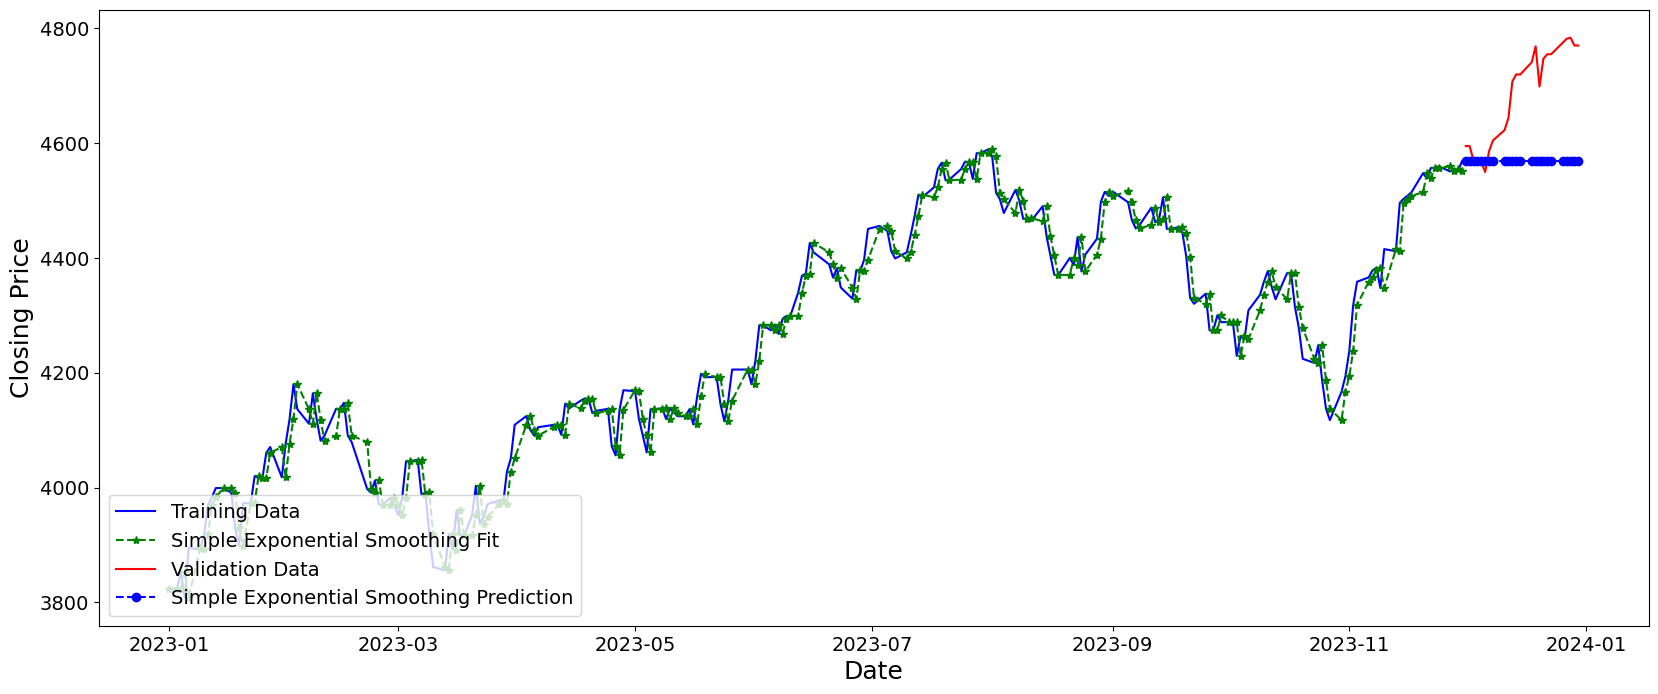

In [63]:
plt.figure(figsize=(20,8))


plt.plot(df_train_val.Date, 
         df_train_val.Close_numeric,
         'b',
         label="Training Data")


## We can get the fitted values with fittedvalues
plt.plot(df_train_val.Date, 
         simp_exp_smooth.fittedvalues,
         'g--*',
         label="Simple Exponential Smoothing Fit")

plt.plot(df_test.Date, 
         df_test.Close_numeric,
         'r',
         label="Validation Data")

## We can get the forecast with .forecast(h)
plt.plot(df_test.Date, 
         simp_exp_smooth.forecast(len(df_test)),
         'b--o',
         label="Simple Exponential Smoothing Prediction")


plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

Exponential Smoothing with diff

In [64]:
pred

array([4567.8, 4567.8, 4567.8, 4567.8, 4567.8, 4567.8, 4567.8, 4567.8,
       4567.8, 4567.8, 4567.8, 4567.8, 4567.8, 4567.8, 4567.8, 4567.8,
       4567.8, 4567.8, 4567.8, 4567.8, 4567.8, 4567.8, 4567.8, 4567.8])

In [65]:
cv = TimeSeriesSplit(n_splits=30, test_size=1)

exp_D_mase = np.zeros((30, 10))
exp_D_rmse = np.zeros((30, 10))
exp_D_c_mase = np.zeros((30, 10))

i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index].copy()# your code here
    df_ho = df_train_val.iloc[test_index].copy()# your code here
    
    j = 0
    for alpha in np.linspace(0.1, 1,10):
        simp_exp_smooth = SimpleExpSmoothing(df_tt.Diff.values).fit(smoothing_level=alpha,
                                                                             optimized=False)
        pred = simp_exp_smooth.forecast(len(df_ho))
        
        exp_D_mase[i,j] = mase(df_tt.Diff.values,df_ho.Diff.values,pred)# your code here
        exp_D_rmse[i,j]=np.sqrt(mean_squared_error(pred,df_ho.Diff.values))
        exp_D_c_mase[i,j]=mase(df_tt.Close_numeric.values, df_ho.Close_numeric.values, df_tt.Close_numeric.iloc[-1]+pred.cumsum())

        j = j + 1
    i = i + 1

In [66]:
np.mean(exp_D_c_mase, axis=0)

array([1.02364851, 1.07994551, 1.10026255, 1.11817321, 1.13312223,
       1.14050562, 1.14493668, 1.16853836, 1.20828385, 1.2758003 ])

In [67]:
jstar=np.linspace(0.1, 1,10)[np.mean(exp_D_mase, axis=0).argmin()]
jstar2=np.linspace(0.1, 1,10)[np.mean(exp_D_c_mase, axis=0).argmin()]

In [68]:
print('EXP with Diff cumsum MASE:', np.mean(exp_D_c_mase, axis=0).min(), ', EXP with Diff MASE:', np.mean(exp_D_mase, axis=0).min(), ', EXP with Diff RMSE:', np.mean(exp_D_rmse, axis=0).min())

EXP with Diff cumsum MASE: 1.0236485133500046 , EXP with Diff MASE: 0.7114368667555754 , EXP with Diff RMSE: 27.219367543308177


In [69]:
cv = TimeSeriesSplit(n_splits=len(df_test), test_size=1)

exp_D_mase = np.zeros((len(df_test), 10))
exp_D_rmse = np.zeros((len(df_test), 10))
exp_D_c_mase = np.zeros((len(df_test), 10))

i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index].copy()# your code here
    df_ho = df_train_val.iloc[test_index].copy()# your code here
    
    j = 0
    for alpha in np.linspace(0.1, 1,10):
        simp_exp_smooth = SimpleExpSmoothing(df_tt.Diff.values).fit(smoothing_level=alpha,
                                                                             optimized=False)
        pred = simp_exp_smooth.forecast(len(df_ho))
        
        exp_D_mase[i,j] = mase(df_tt.Diff.values,df_ho.Diff.values,pred)# your code here
        exp_D_rmse[i,j]=np.sqrt(mean_squared_error(pred,df_ho.Diff.values))
        exp_D_c_mase[i,j]=mase(df_tt.Close_numeric.values, df_ho.Close_numeric.values, df_tt.Close_numeric.iloc[-1]+pred.cumsum())

        j = j + 1
    i = i + 1

In [70]:
len(df_train_val)

244

In [71]:
print('EXP with Diff 1 forcast cumsum MASE:', np.mean(exp_D_c_mase, axis=0).min(), ', EXP with Diff 1 forcast MASE:', np.mean(exp_D_mase, axis=0).min(), ', EXP with Diff 1 forcast RMSE:', np.mean(exp_D_rmse, axis=0).min())

EXP with Diff 1 forcast cumsum MASE: 0.9797486687080315 , EXP with Diff 1 forcast MASE: 0.6836078444007914 , EXP with Diff 1 forcast RMSE: 26.152001384114


In [72]:
simp_exp_smooth_d = SimpleExpSmoothing(df_train_val.Diff.values).fit(smoothing_level=0.9,
                                                                             optimized=False)
simp_exp_smooth_d_c = SimpleExpSmoothing(df_train_val.Diff.values).fit(smoothing_level=np.linspace(0.1, 1,10)[np.mean(exp_D_c_mase, axis=0).argmin()],
                                                                             optimized=False)

pred = simp_exp_smooth_d_c.forecast(len(df_test)).cumsum()+df_train_val.Close_numeric.iloc[-1]

MASE_exp_d_c_t=mase(df_train_val.Close_numeric.values, df_test.Close_numeric.values, pred)
rmse_exp_t=np.sqrt(mean_squared_error(df_test.Close_numeric.values, pred))
print('EXP Diff cumsum test MASE:', MASE_exp_d_c_t , ', EXP Diff cumsum test RMSE:', rmse_exp_t)



EXP Diff cumsum test MASE: 0.3281825527452967 , EXP Diff cumsum test RMSE: 35.51031922340935


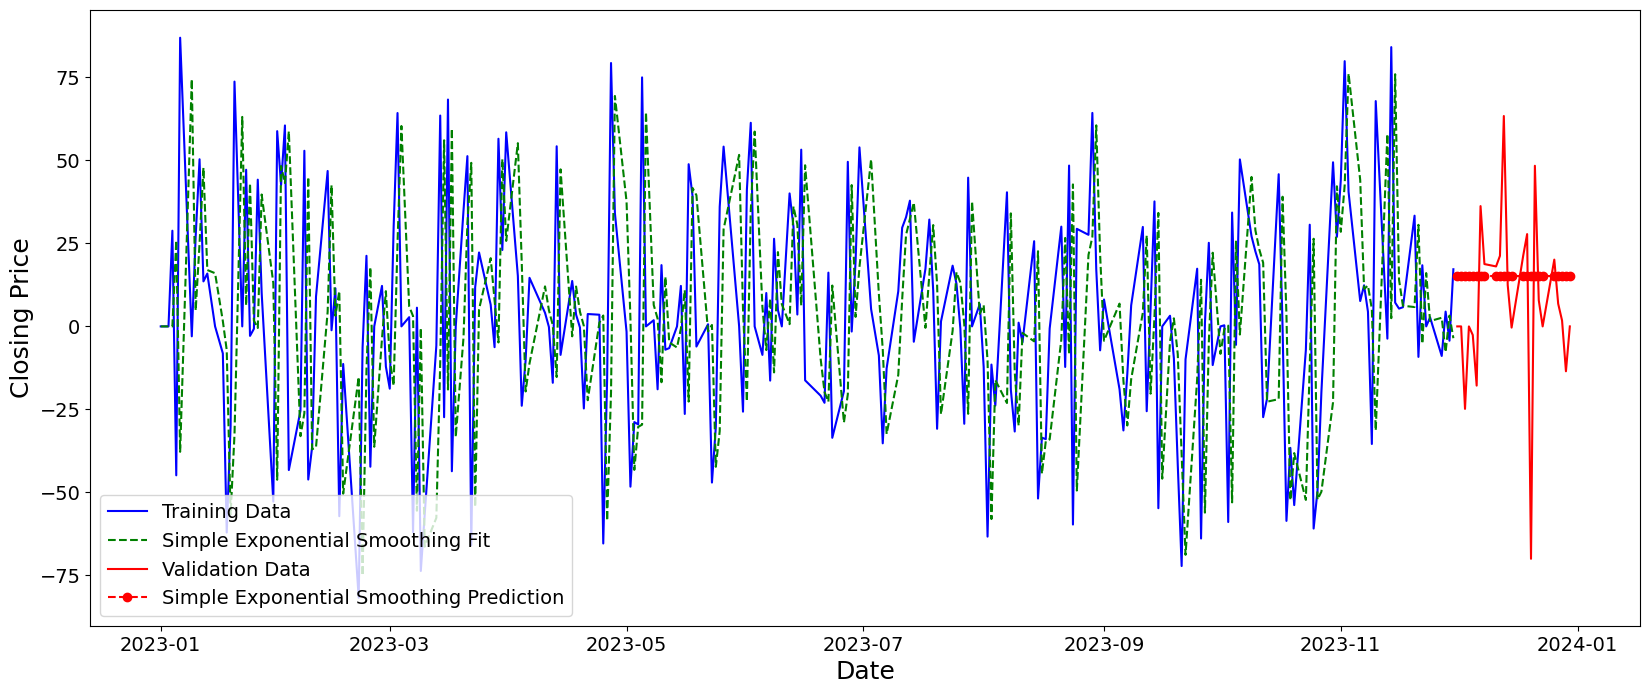

In [73]:
plt.figure(figsize=(20,8))


plt.plot(df_train_val.Date, 
         df_train_val.Diff,
         'b',
         label="Training Data")


## We can get the fitted values with fittedvalues
plt.plot(df_train_val.Date, 
         simp_exp_smooth_d.fittedvalues,
         'g--',
         label="Simple Exponential Smoothing Fit")

plt.plot(df_test.Date, 
         df_test.Diff,
         'r',
         label="Validation Data")

## We can get the forecast with .forecast(h)
plt.plot(df_test.Date, 
         simp_exp_smooth_d.forecast(len(df_test)),
         'r--o',
         label="Simple Exponential Smoothing Prediction")


plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

In [74]:
simp_exp_smooth_d_c.fittedvalues.cumsum()

array([  0.        ,   0.        ,   0.        ,   2.883     ,
         0.9907    ,   7.98563   ,  13.982067  ,  22.0948603 ,
        34.43237427,  46.89213684,  59.69792316,  71.22313084,
        80.78381776,  83.17743598,  82.33069238,  88.94462315,
        94.89716083, 104.97444475, 113.75800027, 121.59020025,
       133.06018022, 144.3961622 , 149.31954598, 159.63359138,
       173.17723224, 191.42150902, 203.51335812, 211.85602231,
       224.65642007, 231.56277807, 234.14250026, 237.36025023,
       244.93922521, 251.64430269, 258.82587242, 259.57028518,
       259.10825666, 250.51743099, 242.1566879 , 236.75901911,
       227.6731172 , 219.49580548, 213.35622493, 206.62160244,
       198.68444219, 194.53699797, 197.23329818, 199.65996836,
       202.12197152, 198.13277437, 195.10649693, 185.01384724,
       170.25746252, 156.39371626, 150.26934464, 142.02141017,
       141.43326916, 136.53994224, 132.13594802, 131.66535322,
       136.37181789, 134.0176361 , 133.07387249, 134.45

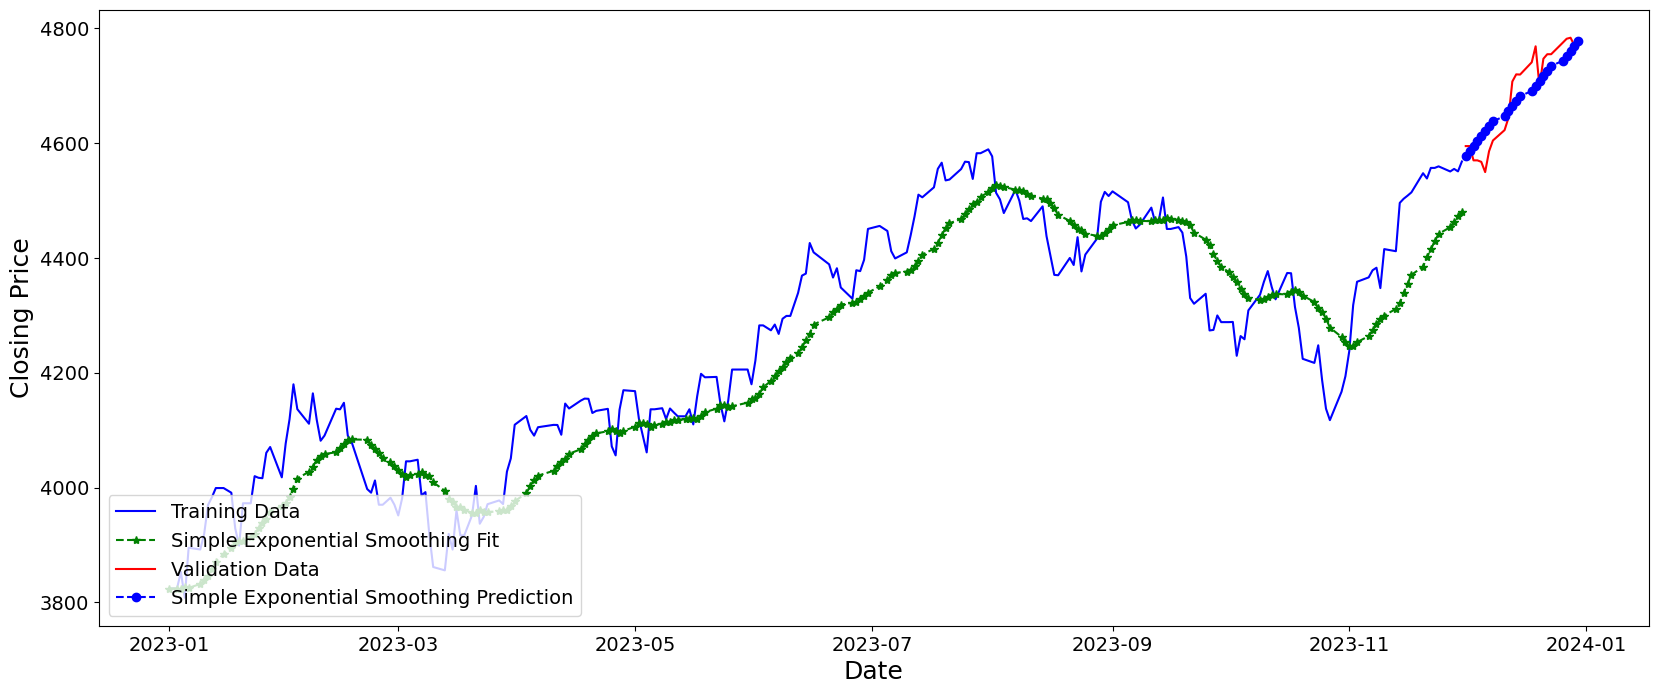

In [75]:
plt.figure(figsize=(20,8))


plt.plot(df_train_val.Date, 
         df_train_val.Close_numeric,
         'b',
         label="Training Data")


## We can get the fitted values with fittedvalues
plt.plot(df_train_val.Date, 
         df_train_val.Close_numeric.iloc[0]+simp_exp_smooth_d_c.fittedvalues.cumsum(),
         'g--*',
         label="Simple Exponential Smoothing Fit")

plt.plot(df_test.Date, 
         df_test.Close_numeric,
         'r',
         label="Validation Data")

## We can get the forecast with .forecast(h)
plt.plot(df_test.Date, 
         simp_exp_smooth_d_c.forecast(len(df_test)).cumsum()+df_train_val.Close_numeric.iloc[-1],
         'b--o',
         label="Simple Exponential Smoothing Prediction")


plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

In [76]:
plt.figure(figsize=(20,8))


plt.plot(df_train_val.Date, 
         df_train_val.Close_numeric-simp_exp_smooth.fittedvalues,
         'b',
         label="Exponential Smoothing Residual Training Data")




plt.xlabel("Date", fontsize=18)
plt.ylabel("Residual", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

ValueError: operands could not be broadcast together with shapes (244,) (243,) 

<Figure size 2000x800 with 0 Axes>

In [77]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_train_val.Diff.values)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistic: -14.902186557670024
p-value: 1.501250902337228e-27
Critical Values:
   1%, -3.4575505077947746
Critical Values:
   5%, -2.8735087323013526
Critical Values:
   10%, -2.573148434859185


Rolling Average

In [78]:
cv = TimeSeriesSplit(n_splits=10, test_size=len(df_val))

start = 1
end = 30
RA_mase = np.zeros((10, len(range(start, end))))
RA_rmse=np.zeros((10, len(range(start, end))))

i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index]
    df_ho = df_train_val.iloc[test_index]
    
    j = 0
    for q in range(start, end):
        pred = df_tt.Close_numeric[-q:].mean() * np.ones(len(df_ho))
        
        RA_mase[i,j] = mase(df_tt.Close_numeric.values, df_ho.Close_numeric.values, pred)
        
        RA_rmse[i,j]=np.sqrt(mean_squared_error(df_tt.Close_numeric[-q:].mean() * np.ones(len(df_ho)),df_ho.Close_numeric.values))
        
        j = j + 1
    i = i + 1



In [79]:
jstar=np.mean(RA_mase, axis=0).argmin()

In [ ]:
jstar

0

In [ ]:
np.mean(RA_mase, axis=0)

array([1.10137201, 1.1548594 , 1.17514097, 1.18776956, 1.1986036 ,
       1.2109062 , 1.22360849, 1.22392067, 1.20799248, 1.19763989,
       1.1960128 , 1.20460158, 1.21049912, 1.22437136, 1.2345346 ,
       1.24661588, 1.25778583, 1.26645906, 1.27182768, 1.27890403,
       1.28973861, 1.30398084, 1.31848844, 1.33586331, 1.3441667 ,
       1.35446774, 1.3646899 , 1.37608022, 1.38909262])

In [ ]:
np.mean(RA_rmse, axis=0)

array([115.55755351, 119.03936094, 120.17425327, 121.19897208,
       121.95700598, 122.99176761, 124.17865807, 124.03326898,
       122.81037777, 122.07963085, 122.43239145, 123.66184696,
       124.50366567, 126.20257612, 127.41991977, 128.76910858,
       129.97542519, 131.25064076, 132.38540281, 133.3662864 ,
       134.78745453, 136.30327313, 137.85988833, 139.52978558,
       140.19332543, 140.97175106, 141.65463496, 142.47905402,
       143.50173487])

In [ ]:
print('RA CV MASE:', np.mean(RA_mase, axis=0).min(), ', RA CV RMSE:', np.mean(RA_rmse, axis=0).min())

RA CV MASE: 1.1013720086324834 , RA CV RMSE: 115.55755350905766


In [93]:
cv = TimeSeriesSplit(n_splits=len(df_val), test_size=1)

start = 1
end = 30
RA_mase = np.zeros((len(df_val), len(range(start, end))))
RA_rmse=np.zeros((len(df_val), len(range(start, end))))
RA_mape=np.zeros((len(df_val), len(range(start, end))))

i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index]
    df_ho = df_train_val.iloc[test_index]
    
    j = 0
    for q in range(start, end):
        pred = df_tt.Close_numeric[-q:].mean() * np.ones(len(df_ho))
        
        RA_mase[i,j] = mase(df_tt.Close_numeric.values, df_ho.Close_numeric.values, pred)
        
        RA_rmse[i,j]=np.sqrt(mean_squared_error(df_tt.Close_numeric[-q:].mean() * np.ones(len(df_ho)),df_ho.Close_numeric.values))
        RA_mape[i,j]=np.mean(np.abs((df_ho.Close_numeric.values - pred) / df_ho.Close_numeric.values)) * 100
        
        j = j + 1
    i = i + 1


In [96]:
RA_rmse.mean(axis=0).min()

22.59363636363634

In [95]:
RA_mase.mean(axis=0).min()

0.8450766224558319

In [94]:
RA_mape.mean(axis=0).min()

0.5118154996230346

In [82]:
qstar=range(start, end)[np.mean(RA_mase, axis=0).argmin()]
pred = df_train_val.Close_numeric[-qstar:].mean() * np.ones(len(df_test))
pred
MASE_ra_t=mase(df_train_val.Close_numeric.values, df_test.Close_numeric.values, pred)
rmse_ra_t=np.sqrt(mean_squared_error(df_test.Close_numeric.values, pred))
print('Average Forcasting test MASE:', MASE_ra_t , ', Average Forcasting test RMSE:', rmse_ra_t)

Average Forcasting test MASE: 1.2403725764477527 , Average Forcasting test RMSE: 141.8792712132395


In [ ]:
len(df_test)

24

Rolling average with diff

In [83]:
cv = TimeSeriesSplit(n_splits=10, test_size=len(df_val))

start = 1
end = 30
RA_D_mase = np.zeros((10, len(range(start, end))))
RA_D_rmse=np.zeros((10, len(range(start, end))))
RA_D_c_mase=np.zeros((10, len(range(start, end))))

i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index]
    df_ho = df_train_val.iloc[test_index]
    
    j = 0
    for q in range(start, end):
        pred = df_tt.Diff[-q:].mean() * np.ones(len(df_ho))
        
        RA_D_mase[i,j] = mase(df_tt.Diff.values, df_ho.Diff.values, pred)
        
        RA_D_rmse[i,j]=np.sqrt(mean_squared_error(df_tt.Diff[-q:].mean() * np.ones(len(df_ho)),df_ho.Diff.values))
        RA_D_c_mase[i,j]=mase(df_tt.Close_numeric.values, df_ho.Close_numeric.values, df_tt.Close_numeric.iloc[-1]+pred.cumsum())

        j = j + 1
    i = i + 1


In [ ]:
np.mean(RA_D_c_mase, axis=0)

array([3.52217358, 3.00853027, 2.45363972, 2.48655029, 2.31506892,
       1.70954733, 1.83470004, 1.85117184, 1.97710174, 1.95045942,
       1.73439755, 1.53901506, 1.57703495, 1.54711061, 1.52684878,
       1.5380433 , 1.42903091, 1.31149932, 1.31500154, 1.25031411,
       1.22066627, 1.21603353, 1.27483835, 1.30314997, 1.21295411,
       1.24861802, 1.24297861, 1.20275487, 1.20364769])

In [ ]:
print('RA with Diff cumsum CV MASE:', np.mean(RA_D_c_mase, axis=0).min(), ', RA with Diff CV MASE:', np.mean(RA_D_mase, axis=0).min(), ', RA with Diff CV RMSE:', np.mean(RA_D_rmse, axis=0).min())

RA with Diff cumsum CV MASE: 1.202754870346856 , RA with Diff CV MASE: 0.6693577924343285 , RA with Diff CV RMSE: 33.514072667575775


In [ ]:
qstar=range(start, end)[np.mean(RA_D_mase, axis=0).argmin()]
pred = df_train_val.Diff[-qstar:].mean() * np.ones(len(df_test))
pred
MASE_ra_d_t=mase(df_train_val.Close_numeric.values, df_test.Close_numeric.values, pred.cumsum()+df_train_val.Close_numeric.iloc[-1])
rmse_ra_d_t=np.sqrt(mean_squared_error(df_test.Close_numeric.values, pred.cumsum()+df_train_val.Close_numeric.iloc[-1]))
print('RA Forcasting with Diff cumsum test MASE:', MASE_ra_d_t , ', RA Forcasting with Diff cumsum test RMSE:', rmse_ra_d_t)

RA Forcasting with Diff cumsum test MASE: 0.40954910822532564 , RA Forcasting with Diff cumsum test RMSE: 45.6508649138231


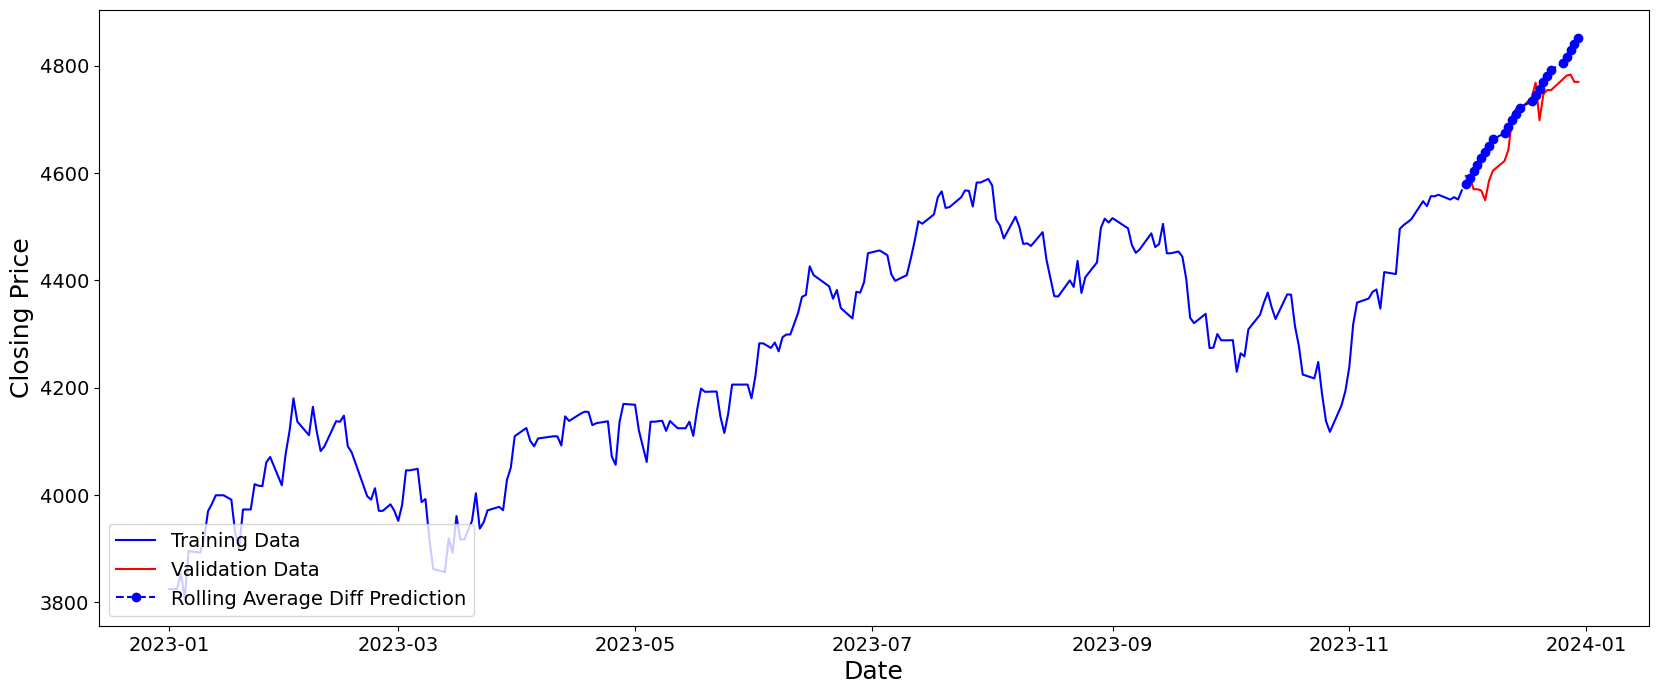

In [ ]:
plt.figure(figsize=(20,8))


plt.plot(df_train_val.Date, 
         df_train_val.Close_numeric,
         'b',
         label="Training Data")




plt.plot(df_test.Date, 
         df_test.Close_numeric,
         'r',
         label="Validation Data")

## We can get the forecast with .forecast(h)
plt.plot(df_test.Date, 
         pred.cumsum()+df_train_val.Close_numeric.iloc[-1],
         'b--o',
         label="Rolling Average Diff Prediction")


plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

Average Forcasting

In [ ]:
cv = TimeSeriesSplit(n_splits=10, test_size=len(df_val))



Av_mase = np.zeros(10)
Av_rmse=np.zeros(10)


i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index]
    df_ho = df_train_val.iloc[test_index]
    
   

    Av_forc=df_tt.Close_numeric.mean()*np.ones(len(df_ho))
    Av_mase[i]=mase(df_tt.Close_numeric.values, df_ho.Close_numeric.values, Av_forc)# your code here
    Av_rmse[i]=np.sqrt(mean_squared_error(df_ho.Close_numeric.values, Av_forc))
   
    i = i + 1

In [ ]:
print('Average CV MASE:', Av_mase.mean(), ', Average CV RMSE:', Av_rmse.mean())

Average CV MASE: 2.129940357456412 , Average CV RMSE: 205.44714326715552


In [ ]:
Aver_forc = df_train_val.Close_numeric.mean()*np.ones(len(df_test))
MASE_av=mase(df_train_val.Close_numeric.values, df_test.Close_numeric.values, Aver_forc )
rmse_av=np.sqrt(mean_squared_error( df_test.Close_numeric.values, Aver_forc))
print('Average Forcasting test MASE:', MASE_av , ', Average Forcasting test RMSE:', rmse_av)

Average Forcasting test MASE: 4.658784514000642 , Average Forcasting test RMSE: 446.1070788974762


Average forcast with Diff

In [ ]:
df_train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           244 non-null    datetime64[ns]
 1   Close          230 non-null    object        
 2   hidden_state   244 non-null    object        
 3   Close_numeric  244 non-null    float64       
 4   Diff           244 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 9.7+ KB


In [ ]:
cv = TimeSeriesSplit(n_splits=10, test_size=len(df_val))



Av_D_mase = np.zeros(10)
Av_D_rmse=np.zeros(10)


i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index]
    df_ho = df_train_val.iloc[test_index]
    
   

    Av_D_forc=df_tt.Diff.mean()*np.ones(len(df_ho))
    Av_D_mase[i]=mase(df_tt.Close_numeric.values, df_ho.Close_numeric.values, Av_D_forc.cumsum()+df_tt.Close_numeric.iloc[-1])# your code here
    Av_D_rmse[i]=np.sqrt(mean_squared_error(df_ho.Close_numeric.values, Av_D_forc.cumsum()+df_tt.Close_numeric.iloc[-1]))
   
    i = i + 1

In [ ]:
print('Average Diff CV MASE:', Av_D_mase.mean(), ', Average Diff CV RMSE:', Av_D_rmse.mean())

Average Diff CV MASE: 1.2187637282793544 , Average Diff CV RMSE: 135.08860469599387


In [ ]:
Aver_forc_D = df_train_val.Diff.mean()*np.ones(len(df_test))
MASE_av_D=mase(df_train_val.Close_numeric.values, df_test.Close_numeric.values, Aver_forc_D.cumsum()+df_train_val.Close_numeric.iloc[-1] )
rmse_av_D=np.sqrt(mean_squared_error(df_test.Close_numeric.values, Aver_forc_D.cumsum()+df_train_val.Close_numeric.iloc[-1]))
print('Average Forcasting with Diff test MASE:', MASE_av_D , ', Average Forcasting with Diff test RMSE:', rmse_av_D)


Average Forcasting with Diff test MASE: 0.8836771240136747 , Average Forcasting with Diff test RMSE: 100.05629688614246


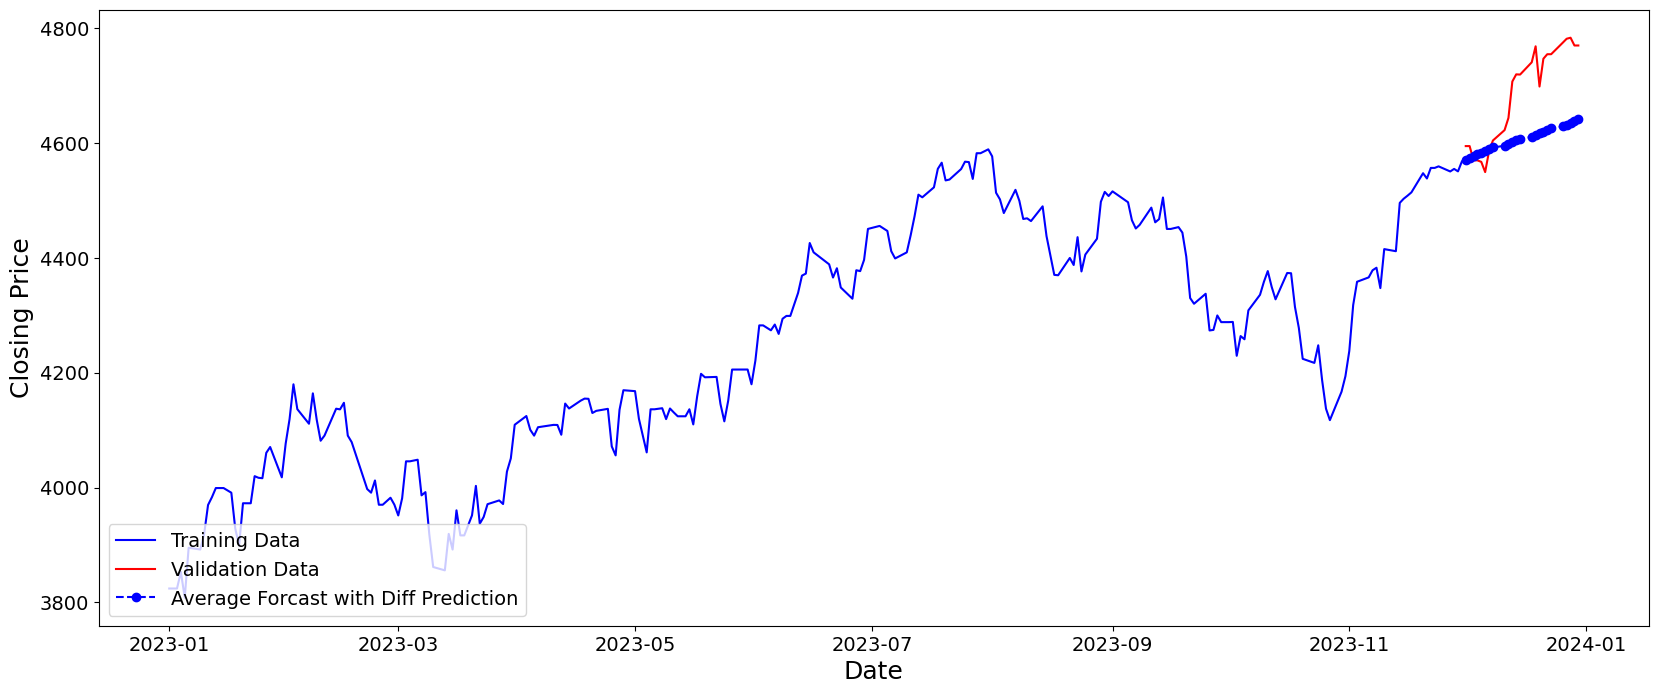

In [ ]:
plt.figure(figsize=(20,8))


plt.plot(df_train_val.Date, 
         df_train_val.Close_numeric,
         'b',
         label="Training Data")




plt.plot(df_test.Date, 
         df_test.Close_numeric,
         'r',
         label="Validation Data")

## We can get the forecast with .forecast(h)
plt.plot(df_test.Date, 
         Aver_forc_D.cumsum()+df_train_val.Close_numeric.iloc[-1],
         'b--o',
         label="Average Forcast with Diff Prediction")


plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

Naive forcasting

In [ ]:
cv = TimeSeriesSplit(n_splits=10, test_size=len(df_val))



N_mase = np.zeros(10)
N_rmse=np.zeros(10)


i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index]
    df_ho = df_train_val.iloc[test_index]
    
   

    N_forc=df_tt.Close_numeric.iloc[-1]*np.ones(len(df_ho))
    N_mase[i]=mase(df_tt.Close_numeric.values, df_ho.Close_numeric.values, N_forc)# your code here
    N_rmse[i]=np.sqrt(mean_squared_error(df_ho.Close_numeric.values, N_forc))
   
    i = i + 1

In [84]:
from sklearn.metrics import mean_absolute_percentage_error
cv = TimeSeriesSplit(n_splits=len(df_val), test_size=1)



N_mase = np.zeros(len(df_val))
N_rmse=np.zeros(len(df_val))
N_mape=np.zeros(len(df_val))


i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index]
    df_ho = df_train_val.iloc[test_index]
    
   

    N_forc=df_tt.Close_numeric.iloc[-1]*np.ones(len(df_ho))
    N_mase[i]=mase(df_tt.Close_numeric.values, df_ho.Close_numeric.values, N_forc)# your code here
    N_rmse[i]=np.sqrt(mean_squared_error(df_ho.Close_numeric.values, N_forc))
    N_mape[i]=mean_absolute_percentage_error(df_ho.Close_numeric.values, N_forc)
   
    i = i + 1

In [86]:
print('Naive CV MASE:', N_mase.mean(), ', Naive CV RMSE:', N_rmse.mean(), 'Naive CV MAPE:', N_mape.mean())

Naive CV MASE: 0.8450766224558321 , Naive CV RMSE: 22.59363636363634 Naive CV MAPE: 0.005118154996230347


In [ ]:
Naive_forc = df_train.Close_numeric.iloc[-1]*np.ones(len(df_val))
MASE_N=mase(df_train.Close_numeric.values, df_val.Close_numeric.values, Naive_forc)
rmse_N=np.sqrt(mean_squared_error(df_val.Close_numeric.values, Naive_forc))
print('Naive Forcasting test MASE:', MASE_N , ', Naive Forcasting test RMSE:', rmse_N)

Naive Forcasting test MASE: 3.118549776283127 , Naive Forcasting test RMSE: 287.4012921540509


Naive Forcasting with Diff

In [ ]:

cv = TimeSeriesSplit(n_splits=10, test_size=len(df_val))



N_D_mase = np.zeros(10)
N_D_rmse=np.zeros(10)


i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index]
    df_ho = df_train_val.iloc[test_index]
    
   

    N_D_forc=df_tt.Diff.iloc[-1]*np.ones(len(df_ho))
    N_D_mase[i]=mase(df_tt.Close_numeric.values, df_ho.Close_numeric.values, N_D_forc.cumsum()+df_tt.Close_numeric.iloc[-1])# your code here
    N_D_rmse[i]=np.sqrt(mean_squared_error(df_ho.Close_numeric.values, N_D_forc.cumsum()+df_tt.Close_numeric.iloc[-1]))
   
    i = i + 1

In [ ]:
print('Naive with Diff cumsum CV MASE:', N_D_mase.mean(),  ', Naive with Diff cumsum CV RMSE:', N_D_rmse.mean())

Naive with Diff cumsum CV MASE: 3.522173576208304 , Naive with Diff cumsum CV RMSE: 409.507720439708


In [ ]:
Naive_forc_D= df_train_val.Diff.iloc[-1]*np.ones(len(df_test))
MASE_N_D=mase(df_train_val.Close_numeric.values, df_test.Close_numeric.values, Naive_forc_D.cumsum()+df_train_val.Close_numeric.iloc[-1] )
rmse_N_D=np.sqrt(mean_squared_error(df_test.Close_numeric.values, Naive_forc_D.cumsum()+df_train_val.Close_numeric.iloc[-1]))
print('Naive Forcasting Diff test MASE:', MASE_N_D , ', Naive Forcasting Diff test RMSE:', rmse_N_D)

Naive Forcasting Diff test MASE: 1.0728231235750136 , Naive Forcasting Diff test RMSE: 113.07672041583457


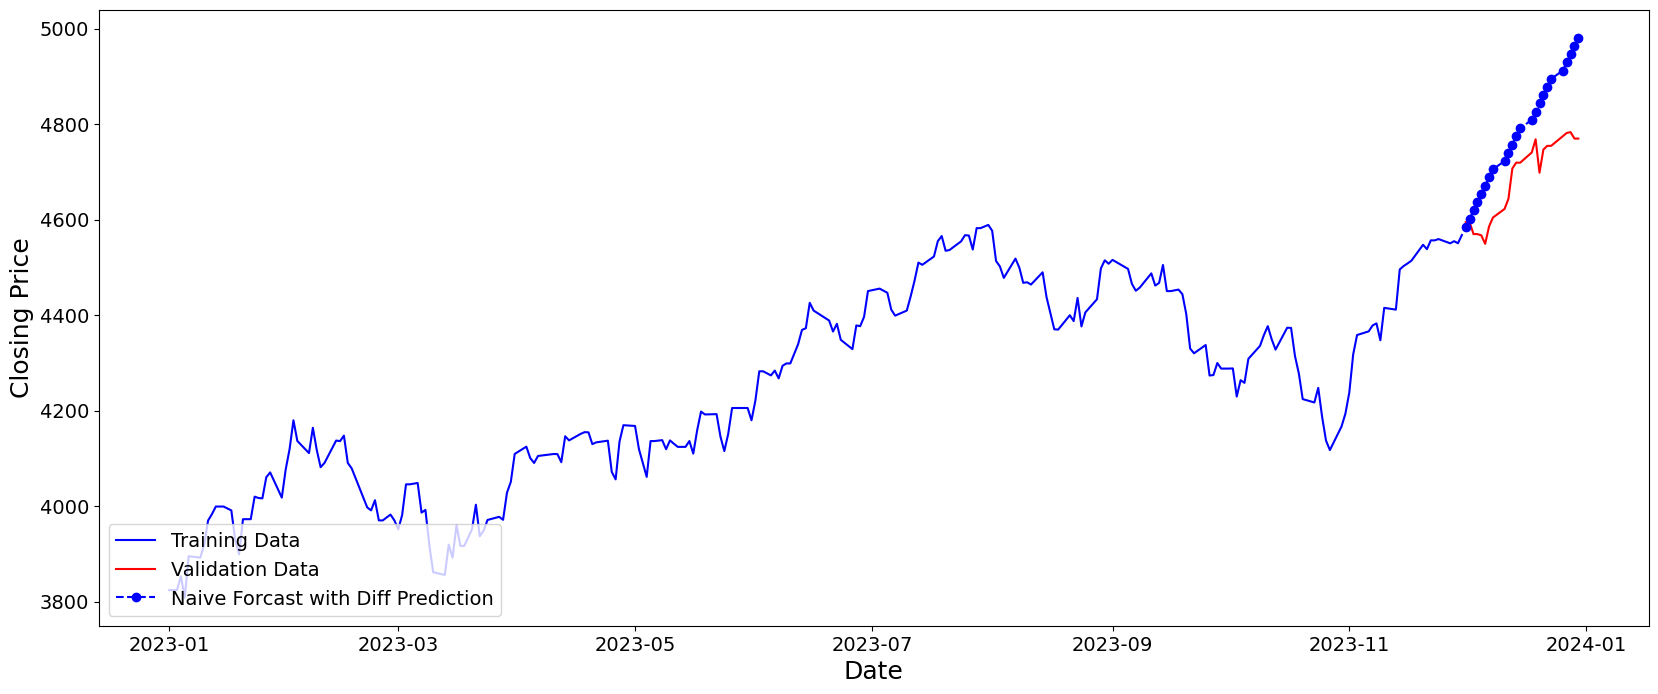

In [ ]:
plt.figure(figsize=(20,8))


plt.plot(df_train_val.Date, 
         df_train_val.Close_numeric,
         'b',
         label="Training Data")

plt.plot(df_test.Date, 
         df_test.Close_numeric,
         'r',
         label="Validation Data")

## We can get the forecast with .forecast(h)
plt.plot(df_test.Date, 
         Naive_forc_D.cumsum()+df_train_val.Close_numeric.iloc[-1],
         'b--o',
         label="Naive Forcast with Diff Prediction")


plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

Linear Trend Model

In [ ]:
df_val.index

RangeIndex(start=0, stop=22, step=1)

In [ ]:
from sklearn.linear_model import LinearRegression
cv = TimeSeriesSplit(n_splits=10, test_size=len(df_val))

reg=LinearRegression()

Reg_mase = np.zeros(10)
Reg_rmse=np.zeros(10)


i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index]
    df_ho = df_train_val.iloc[test_index]
    
   

    reg.fit(np.arange(0,len(df_tt)).reshape(-1,1), df_tt.Close_numeric.values.reshape(-1,1))
    Reg_forc=reg.predict(np.arange(len(df_tt),len(df_tt)+len(df_ho)).reshape(-1,1))
    Reg_mase[i]=mase(df_tt.Close_numeric.values, df_ho.Close_numeric.values, Reg_forc )
    Reg_rmse[i]=np.sqrt(mean_squared_error(df_ho.Close_numeric.values, Reg_forc))
   
    i = i + 1


In [ ]:
print('Linear Trend Model CV MASE:', Reg_mase.mean(), ', Linear Trend Model CV RMSE:', Reg_rmse.mean())

Linear Trend Model CV MASE: 1.4974373181736482 , Linear Trend Model CV RMSE: 157.21973975561107


In [ ]:

reg.fit(np.arange(0,len(df_train_val)).reshape(-1,1), df_train_val.Close_numeric.values.reshape(-1,1))
Reg_forc=reg.predict(np.arange(len(df_train_val),len(df_train_val)+len(df_test)).reshape(-1,1))
MASE_R=mase(df_train_val.Close_numeric.values, df_test.Close_numeric.values, Reg_forc )
rmse_R=np.sqrt(mean_squared_error( df_test.Close_numeric.values, Reg_forc))
print('Reg Forcasting test MASE:', MASE_R, ', Reg Forcasting test RMSE:', rmse_R)

Reg Forcasting test MASE: 1.342171498232899 , Reg Forcasting test RMSE: 142.01429730170895


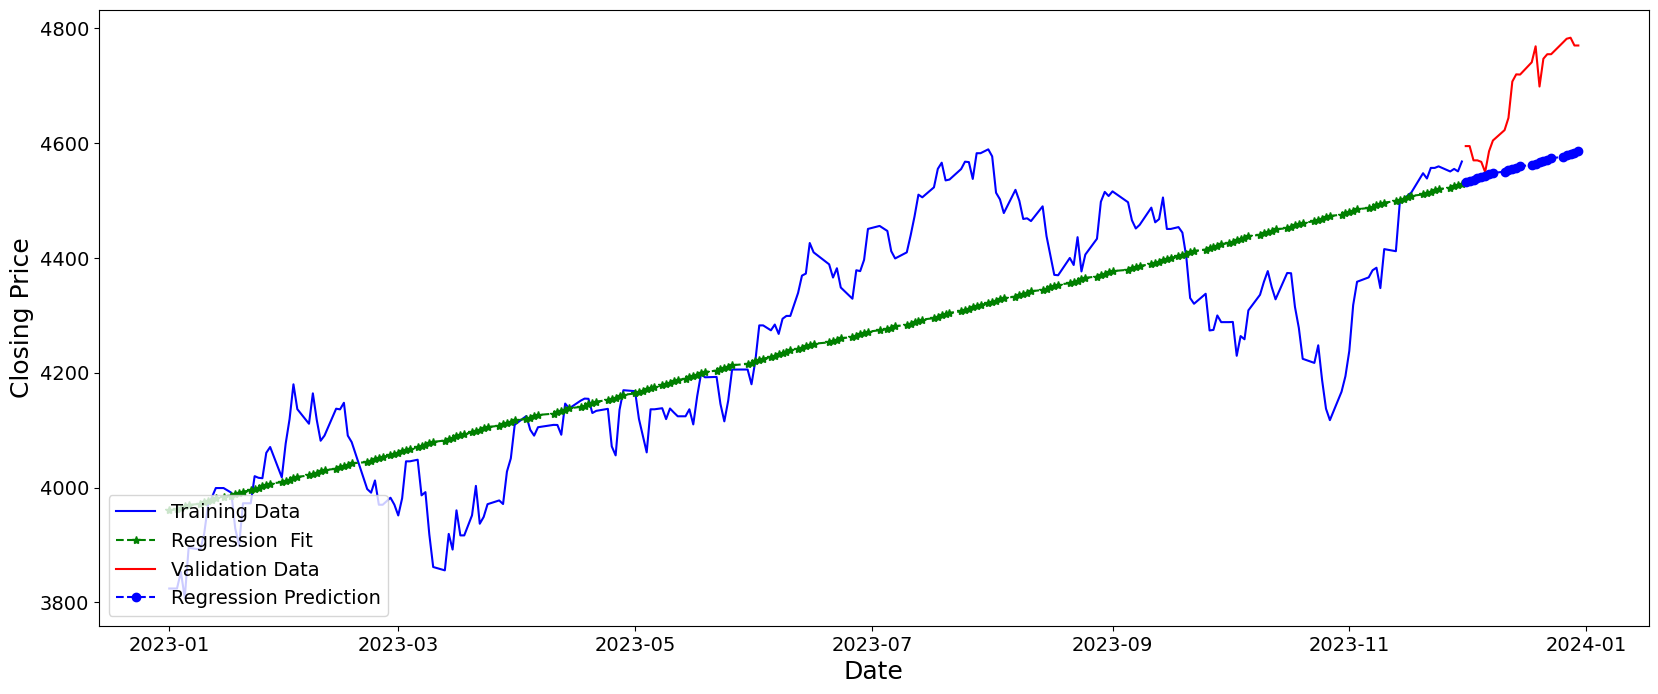

In [ ]:
plt.figure(figsize=(20,8))


plt.plot(df_train_val.Date, 
         df_train_val.Close_numeric,
         'b',
         label="Training Data")


## We can get the fitted values with fittedvalues
plt.plot(df_train_val.Date, 
         reg.predict(np.arange(len(df_train_val)).reshape(-1,1)),
         'g--*',
         label="Regression  Fit")

plt.plot(df_test.Date, 
         df_test.Close_numeric,
         'r',
         label="Validation Data")

## We can get the forecast with .forecast(h)
plt.plot(df_test.Date, 
         Reg_forc,
         'b--o',
         label="Regression Prediction")


plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

Random Walk with Drift

In [ ]:

cv = TimeSeriesSplit(n_splits=10, test_size=len(df_val))



Dr_mase = np.zeros(10)
Dr_rmse=np.zeros(10)


i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index]
    df_ho = df_train_val.iloc[test_index]

    beta_hat = (df_tt.Close_numeric.values[-1] - df_tt.Close_numeric.values[0])/len(df_tt)
    drift_pred = df_tt.Close_numeric.values[-1] + beta_hat * np.arange(1,len(df_ho) + 1)
   

    Dr_mase[i]=mase(df_tt.Close_numeric.values, df_ho.Close_numeric.values, drift_pred )
    Dr_rmse[i]=np.sqrt(mean_squared_error(df_ho.Close_numeric.values, drift_pred))
   
    i = i + 1

In [103]:

cv = TimeSeriesSplit(n_splits=len(df_val), test_size=1)



Dr_mase = np.zeros(len(df_val))
Dr_rmse=np.zeros(len(df_val))
Dr_mape=np.zeros(len(df_val))


i = 0
for train_index, test_index in cv.split(df_train_val):
    df_tt = df_train_val.iloc[train_index]
    df_ho = df_train_val.iloc[test_index]

    beta_hat = (df_tt.Close_numeric.values[-1] - df_tt.Close_numeric.values[0])/len(df_tt)
    drift_pred = df_tt.Close_numeric.values[-1] + beta_hat * np.arange(1,len(df_ho) + 1)
   

    Dr_mase[i]=mase(df_tt.Close_numeric.values, df_ho.Close_numeric.values, drift_pred )
    Dr_rmse[i]=np.sqrt(mean_squared_error(df_ho.Close_numeric.values, drift_pred))
    Dr_mape[i]=np.mean(np.abs(df_ho.Close_numeric.values-drift_pred)/df_ho.Close_numeric.values)*100

   
    i = i + 1

In [366]:
beta_hat

2.989465020576132

In [88]:
print('Random Walk with Drift CV MASE:', Dr_mase.mean(), ', Random Walk with Drift CV RMSE:', Dr_rmse.mean(), 'Random Walk with Drift CV MAPE:', Dr_mape.mean())

Random Walk with Drift CV MASE: 0.8051315480815191 , Random Walk with Drift CV RMSE: 21.521916177018117 Random Walk with Drift CV MAPE: 0.004876943489638023


In [336]:
beta_hat = (df_train_val.Close_numeric.values[-1] - df_train_val.Close_numeric.values[0])/len(df_train_val)
drift_pred = df_train_val.Close_numeric.values[-1] + beta_hat*np.arange(1,len(df_test) + 1)
sigma = np.sqrt(((df_train_val.Close_numeric.diff() - beta_hat)**2).sum()/len(df_train_val))

MASE_Drift=mase(df_train_val.Close_numeric.values, df_test.Close_numeric.values, drift_pred )
rmse_Drift=np.sqrt(mean_squared_error( df_test.Close_numeric.values, drift_pred))
print('Random walk with drift Forcasting test MASE:', MASE_Drift, ', Random walk with drift Forcasting test RMSE:', rmse_Drift)

Random walk with drift Forcasting test MASE: 0.8836771240136747 , Random walk with drift Forcasting test RMSE: 100.05629688614246


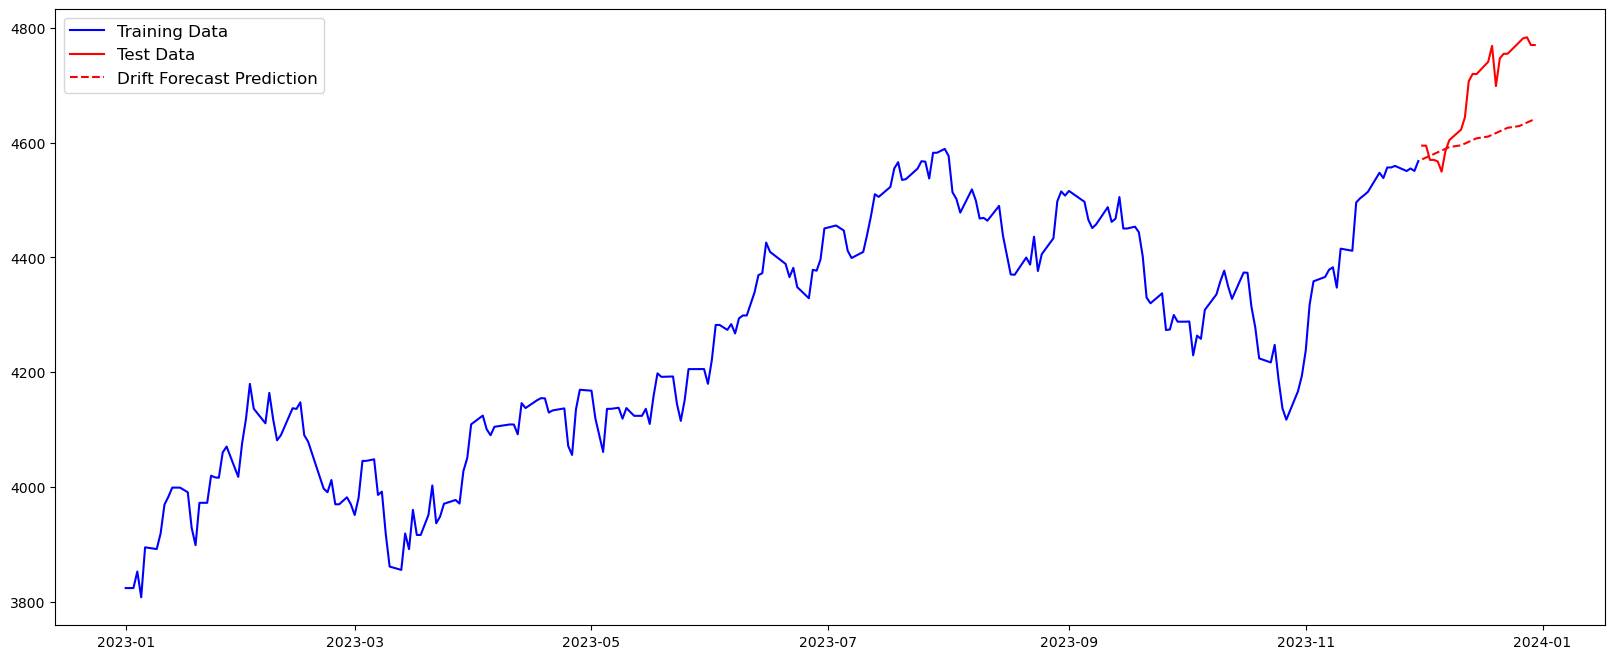

In [301]:
plt.figure(figsize=(20,8))

plt.plot(df_train_val.Date,
            df_train_val.Close_numeric,
            'b-',
            label="Training Data")

plt.plot(df_test.Date,
            df_test.Close_numeric,
            'r-',
            label="Test Data")

plt.plot(df_test.Date,
            drift_pred,
            'r--',
            label="Drift Forecast Prediction")

plt.legend(fontsize=12, loc=2)

plt.show()

In [91]:
mase_r

0.8450766224558321

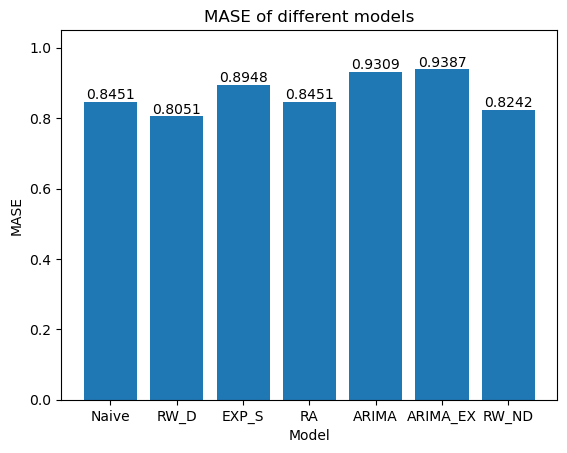

In [114]:
x=['Naive','RW_D', 'EXP_S', 'RA', 'ARIMA', 'ARIMA_EX','RW_ND']
y=[np.round(N_mase.mean(),4), np.round(Dr_mase.mean(),4), np.round(exp_mase.mean(axis=0).min(),4), np.round(RA_mase.mean(axis=0).min(),4), 0.9309,  0.9387, 0.8242]
plt.bar(x,y)

for i, v in enumerate(y):
    plt.annotate(str(v), xy=(i, v), ha='center', va='bottom')

plt.ylabel('MASE')
plt.xlabel('Model')
plt.ylim(0,1.05)
plt.title('MASE of different models')
plt.savefig('MASE_models.png')

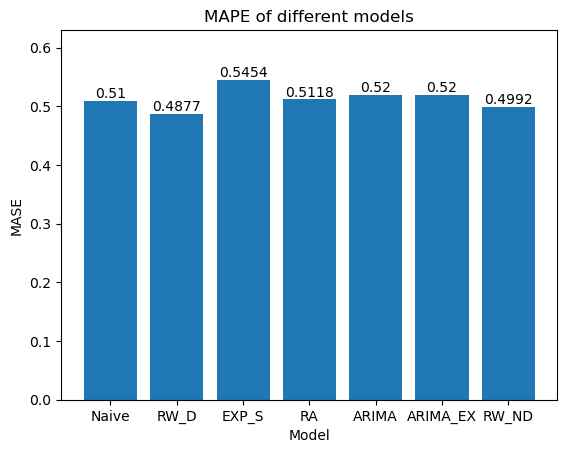

In [117]:
x=['Naive','RW_D', 'EXP_S', 'RA', 'ARIMA', 'ARIMA_EX','RW_ND']
y=[np.round(N_mape.mean(),4)*100, np.round(Dr_mape.mean(),4), np.round(exp_mape.mean(axis=0).min()*100,4), np.round(RA_mape.mean(axis=0).min(),4), 0.52,  0.52, 0.4992]
plt.bar(x,y)

for i, v in enumerate(y):
    plt.annotate(str(v), xy=(i, v), ha='center', va='bottom')


plt.ylabel('MASE')
plt.xlabel('Model')
plt.ylim(0,0.63)
plt.title('MAPE of different models')
plt.savefig('MAPE_models.png')

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the data for the bar plot
x = ['A', 'B', 'C', 'D']
y = [10, 20, 15, 25]

# Create the bar plot
plt.bar(x, y)

# Add the value of each bar on top of them
for i, v in enumerate(y):
    plt.annotate(str(v), xy=(i, v), ha='center', va='bottom')

# Show the plot
plt.show()